### Binary protrusion segmentation

The task of binary segmentation is to label each vertex (or alternatively face) of a mesh as being on a protrusion - 1, or not on a protrusion - 0.   

We will do this by measuring the 'height' of a vertex from a constructed reference. 

<div class="alert alert-block alert-info"> 
<b>NOTE</b> The reference used for measuring height need not be that used for unwrapping. It may be more optimal to construct a different reference depending on the problem as we show.
</div>

The mesh we we will use to demonstrate is `../../data/mesh/lamellipodia_cell.obj`, as well as its corresponding topography mesh `../../data/mesh/topography/curvature_topographic_mesh_lamellipodia_cell.obj`. The method demonstrated generalizes for all protrusions, but may require tweaking of parameters. 

#### 0. Read in the surface mesh

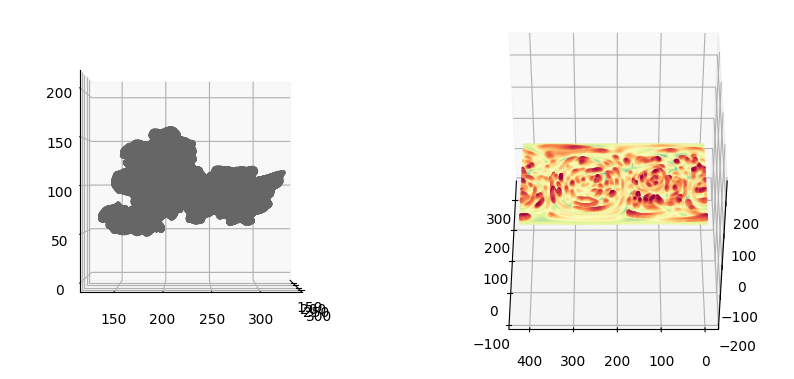

In [88]:
import unwrap3D.Mesh.meshtools as meshtools
import unwrap3D.Segmentation.segmentation as segmentation
import unwrap3D.Utility_Functions.file_io as fio # for common IO functions
import unwrap3D.Unzipping.unzip as uzip
import unwrap3D.Visualisation.colors as vol_colors
import unwrap3D.Visualisation.plotting as plotting

from matplotlib import cm 
import os
import numpy as np
import pylab as plt 

"""
Specifying image file location and parsing its name. 
"""
meshfolder = '../../data/mesh'
meshfile = os.path.join(meshfolder, 'lamellipodia_cell.obj')

basefname = os.path.split(meshfile)[-1].split('.obj')[0] # get the filename with extension

mesh_S = meshtools.read_mesh(meshfile,
                             keep_largest_only=True) # read only the largest if there is multiple separate objects in the mesh

"""
Also get its topography mesh
"""
topo_meshfile = os.path.join(meshfolder, 'topography', 'curvature_topographic_mesh_lamellipodia_cell.obj')
mesh_S_duv = meshtools.read_mesh(topo_meshfile, 
                                 keep_largest_only=True)

"""
Create a master save folder
"""
savefolder = os.path.join('example_results', 
                         basefname)
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


"""
Visualize the input mesh
"""
sampling = 1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.5, 
            c=mesh_S.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.5, 
            c=mesh_S_duv.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(45,180)
plotting.set_axes_equal(ax)
plt.show()


#### 1. Defining a vertex-based protrusion height 

The function should measure protrusion 'height'. However, the height of a protrusion is a relative concept, necessarily requiring a reference surface to measure with respect to. 

We explore 3 different constructions of a reference surface to derive 3 different heights for binary segmentation:

- cMCF $S_\text{ref}(x,y,z)$
- cMCF + distance function $S_\text{ref}(x,y,z)$ 
- asymmetric least squares (ALS) baseline reference,$S_\text{ref}(d,u,v)$ (for $S(d,u,v)$ only)

##### cMCF $S_\text{ref}(x,y,z)$

Running cMCF and stopping criteria for this cell was explained as a fully worked example in the standard workflow section. For clarity, we repeat the code here, and recompute the reference here 

In [89]:
Usteps_MCF_img, mesh_F, MCF_measures_dict = meshtools.conformalized_mean_curvature_flow(mesh_S, 
                                                                                    max_iter=50, 
                                                                                    rescale_output = True, # cMCF is solved in normalized coordinates, when True, the output will be rescaled to be in image coordinates.  
                                                                                    delta=5e-4, 
                                                                                    conformalize=True, # set this flag to run cMCF, else it will run MCF
                                                                                    robust_L =False, # if set, runs MCF/cMCF using the robust Laplacian instead of cotangent Laplacian
                                                                                    mollify_factor=1e-5, # this is a parameter used in the robust Laplacian
                                                                                    solver='pardiso')  # 'scipy': standard scipy solver, 'pardiso' for using Intel's pardiso solver to solve in parallel. 'pariso' is much faster. But you must use 'scipy' if you plan to multiprocess over different cells.

gauss_curve_MCF = MCF_measures_dict['gauss_curvature_iter'].copy()

# find changepoints in the curve, generally default is fine.
inds = meshtools.find_all_curvature_cutoff_index(gauss_curve_MCF, 
                                                 avg_fnc=np.nanmean, # use moving means 
                                                 absval=True, # absolute value after subtracting baseline 
                                                 winsize=11, # window size for moving means, larger tends to slightly bias the found iteration number to later 
                                                 min_peak_height=1e-7, # minimum peak height
                                                 min_peak_distance=5) # minimal distance between detected peaks. 

cMCF_S_ref = mesh_S.copy()
cMCF_S_ref.vertices = Usteps_MCF_img[...,inds[0]]


100%|██████████| 50/50 [04:43<00:00,  5.67s/it]


The number of vertices of input and output is the same. Height is defined as the total curvilinear distance traversed from $S(x,y,z)$ to $S_\text{ref}(x,y,z)$  

$$
h_\text{cMCF} = \text{sgn}(S(x,y,z))\left (\sum_{i=0}^{i_\text{cMCF}-1} \left| S_{i+1}(x,y,z)-S_i(x,y,z)\right|\right )
$$

where $i$ is the iteration index of cMCF so that $S_\text{ref}(x,y,z)=S_{i_\text{cMCF}}(x,y,z)$, and $\text{sgn}(\cdot)$ is +1 if the vertex on $S(x,y,z)$ is exterior of $S_\text{ref}(x,y,z)$ and -1 if interior of $S_\text{ref}(x,y,z)$.

In [90]:
# compute sgn(S(x,y,z)) by checking the sign of the cosine distance between the displacement vector of S to S_ref with the surface normal vector of S
# If the sign is positive, this means S is exterior of S_ref. Otherwise it is interior of S_ref

sign_h_cMCF = np.sign(np.nansum((mesh_S.vertices - cMCF_S_ref.vertices)*mesh_S.vertex_normals, axis=-1))

# compute the summed distances up to the S_ref cMCF iteration index
dist_cMCF = np.nansum(np.linalg.norm(Usteps_MCF_img[...,1:inds[0]+1]-Usteps_MCF_img[...,0:inds[0]], axis=1), axis=-1)

# combine
h_cMCF = sign_h_cMCF * dist_cMCF

##### cMCF + distance function $S_\text{ref}(x,y,z)$ 

We use active contours to perform a curvature minimizing flow guided by the Harmonic distance transform distance function of the input shape. This will specifically erode positive curvature protrusions most, and negative curvature protrusions least. The advantage of this method is it guarantees intermediate shapes stay within the input shape. Moreover, by targeting positive protrusions, the result is a much tighter estimate of the shape minus protrusions.

In [91]:
# construct the SDF of the input mesh after voxelization it 
mesh_S_binary = meshtools.voxelize_image_mesh_pts(mesh_S, 
                                                  pad=15, 
                                                  dilate_ksize=2,
                                                  erode_ksize=2)

# use the poisson instead. 
import scipy.ndimage as ndimage
ds_factor = 1/2. # try to use highest posssible (closest to 1) that computes in reasonable speed to capture best resolution
mesh_S_binary_ds = ndimage.zoom(mesh_S_binary*255., zoom=[ds_factor, ds_factor, ds_factor],order=1) > 0.5
poisson_dtform_ds = segmentation.poisson_dist_tform_3D(mesh_S_binary_ds, pts=None)
poisson_dtform = ndimage.zoom(poisson_dtform_ds, zoom=np.hstack(mesh_S_binary.shape)/np.hstack(mesh_S_binary_ds.shape).astype(np.float32))

print(mesh_S_binary.shape, poisson_dtform.shape)


laplacian 3D construction... 13.588892698287964
(317, 343, 177) (317, 343, 177)


In [92]:
import scipy.ndimage as ndimage

sdf_vol_normal = np.array(np.gradient(poisson_dtform))
sdf_vol_normal = sdf_vol_normal/(np.linalg.norm(sdf_vol_normal, axis=0)[None,...]+1e-20)
sdf_vol_normal = np.array([ndimage.gaussian_filter(sdf_vol_normal[iii], sigma=3) for iii in np.arange(3)])
sdf_vol_normal = sdf_vol_normal/(np.linalg.norm(sdf_vol_normal,axis=0)[None,...]+1e-20)

H_normal = segmentation.mean_curvature_field(sdf_vol_normal)

# multiply the gradient field by the rescaled H_normal
sdf_vol_normal = sdf_vol_normal*meshtools._normalize99(np.abs(H_normal))[None,...] # set a minimum speed. 

print(sdf_vol_normal.shape)

"""
Perform active contours
"""
Usteps_external = meshtools.parametric_mesh_constant_img_flow(mesh_S, 
                                                            external_img_gradient=sdf_vol_normal.transpose(1,2,3,0), 
                                                            deltaL = 5e-2,
                                                              niters=100,  
                                                              step_size=1, 
                                                              method='implicit', 
                                                              robust_L=False, 
                                                              mollify_factor=1e-5,
                                                              conformalize=False, # use active contours 
                                                              eps=1e-12,
                                                              alpha=0.1,
                                                              beta=0.5, 
                                                              solver='pardiso', 
                                                              normalize_grad=False)

(3, 317, 343, 177)


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


Similar to cMCF compute the discrete Gaussian curvature to monitor the changes in shape. Unlike cMCF we don't look for changepoints, but instead take the minimum value (the smoothest mesh) to define the reference shape, $S_\text{ref}^\text{external}(x,y,z)$. 

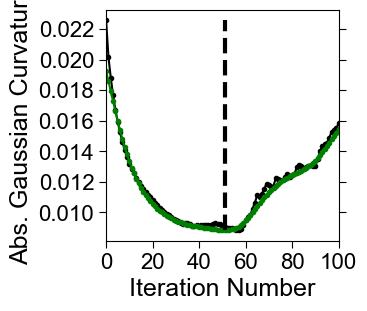

In [93]:
import igl
import unwrap3D.Analysis_Functions.timeseries as tsa

gauss_curve_vals_iters = [igl.gaussian_curvature(Usteps_external[...,step_ii], mesh_S.faces) for step_ii in np.arange(Usteps_external.shape[-1])]
gauss_curve_MCF = np.hstack([np.nanmean(np.abs(gauss_curve_vals_iter)) for gauss_curve_vals_iter in gauss_curve_vals_iters])

# this curve is noisy, therefore we can try smoothing before taking
gauss_curve_MCF_smooth = tsa.baseline_als(gauss_curve_MCF, lam=1e2, p=0.1, niter=10)
ind = np.argmin(gauss_curve_MCF_smooth)

"""
plot the evolution of the curve and mark the iteration of minimum curvature
"""

fig, ax = plt.subplots(figsize=(3,3))
plt.plot(np.arange(len(gauss_curve_MCF)), 
          gauss_curve_MCF, '.-', color='k')
plt.plot(np.arange(len(gauss_curve_MCF)), 
          gauss_curve_MCF_smooth, '.-', color='g')
plt.vlines(ind, 
            np.min(gauss_curve_MCF), 
            np.max(gauss_curve_MCF), 'k', linestyles='dashed', lw=3)
plt.tick_params(length=5, right=True)
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.xlim([0,Usteps_external.shape[-1]-1])
plt.xlabel('Iteration Number', fontsize=18, fontname='Arial')
plt.ylabel('Abs. Gaussian Curvature', fontsize=18, fontname='Arial')
plt.savefig(os.path.join(savefolder, 
                          'external_MCF_iterations_'+basefname.replace('.tif', '.svg')), bbox_inches='tight')
plt.show()


In [94]:
external_ref_mesh = mesh_S.copy()
external_ref_mesh.vertices = Usteps_external[...,ind].copy()
tmp = external_ref_mesh.export(os.path.join(savefolder, 
                                   'external_cMCF_Sref.obj'))


The number of vertices of input and output is the same. Height is defined as the total curvilinear distance traversed from $S(x,y,z)$ to $S_\text{ref}(x,y,z)$  

$$
h_\text{external cMCF} = \text{sgn}(S(x,y,z))\left (\sum_{i=0}^{i_\text{external cMCF}-1} \left| S_{i+1}(x,y,z)-S_i(x,y,z)\right|\right )
$$

where $i$ is the iteration index of external cMCF so that $S_\text{ref}(x,y,z)=S_{i_\text{external cMCF}}(x,y,z)$, and $\text{sgn}(\cdot)$ is +1 if the vertex on $S(x,y,z)$ is exterior of $S_\text{ref}(x,y,z)$ and -1 if interior of $S_\text{ref}(x,y,z)$.

In [95]:
# compute sgn(S(x,y,z)) by checking the sign of the cosine distance between the displacement vector of S to S_ref with the surface normal vector of S
# If the sign is positive, this means S is exterior of S_ref. Otherwise it is interior of S_ref

sign_h_external_cMCF = np.sign(np.nansum((mesh_S.vertices - external_ref_mesh.vertices)*mesh_S.vertex_normals, axis=-1))

# compute the summed distances up to the S_ref cMCF iteration index
dist_external_cMCF = np.nansum(np.linalg.norm(Usteps_external[...,1:ind+1]-Usteps_external[...,0:ind], axis=1), axis=-1)

# combine
h_external_cMCF = sign_h_external_cMCF * dist_external_cMCF

##### ALS baseline $S^{\text{ALS}}_\text{ref}(d,u,v)$

We modify the original [asymmetric least squares filter](https://www.researchgate.net/publication/228961729_Baseline_Correction_with_Asymmetric_Least_Squares_Smoothing) also known as the Whittaker filter which can be used to find baselines for 1D data, to work for topography $(d,u,v)$ surfaces. Specifically, we operate on the binary topography volume image of the mesh. 

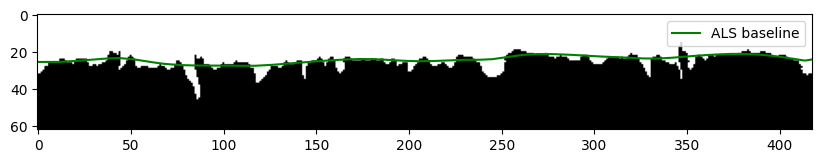

In [96]:
import skimage.io as skio 
import scipy.io as spio 

# read the topography volume image of the cell 
binary_topography_file = os.path.join(meshfolder, 'topography', 'topography_binary.tif')
binary_topography_volume = skio.imread(binary_topography_file)

# read the topography space 
topography_space_file = os.path.join(meshfolder, 'topography', 'topographic_volume_space.mat')
topography_space_obj = spio.loadmat(topography_space_file)

topographic_coordinates = topography_space_obj['topographic_map']

"""
Make topography volume so that the surface is 1-to-1 with a (u,v) pixel
i.e. S(d,u,v) is converted to the surface parameterization, d=F(u,v) 
""" 
import unwrap3D.Analysis_Functions.topography as topotools

d_surface = topotools.estimate_base_topography_uv_img(binary_topography_volume>0)
vu_coords_d_surface = d_surface[...,1:].copy()
d_surface = d_surface[...,0].copy()


"""
run ALS on d=F(u,v) to get a baseline d_base = G(u,v)
""" 
# regularized baseline estimation. -> this outputs an image 
d_surface_ALS = topotools.penalized_smooth_topography_uv_img(d_surface, 
                                                            ds=8, # controls the smoothness of the baseline, increase to get smoother/flatter, decrease up to 1 to retain more ruggedness. 
                                                            padding_multiplier=4, 
                                                            method='ALS', 
                                                            lam=1,
                                                            p=0.25,  # decrease for more asymmetric.
                                                            niter=10) # niter is for convergence, 10 pretty much always converge
                                                            
# plot the cross-section of a mid-slice with the binary topography volume
d_surface_ALS_midsection = d_surface_ALS[binary_topography_volume.shape[1]//2].copy()

plt.figure(figsize=(10,10))
plt.imshow(binary_topography_volume[:,binary_topography_volume.shape[1]//2], cmap='gray')
plt.plot(np.arange(len(d_surface_ALS_midsection)),
         d_surface_ALS_midsection,
         'g', label='ALS baseline')
plt.legend()
plt.show()


"""
Interpolate this for the mesh
"""
import unwrap3D.Image_Functions.image as image_fn

topo_mesh_d_ref_ALS = image_fn.map_intensity_interp2(mesh_S_duv.vertices[:,1:], 
                                                grid_shape=d_surface_ALS.shape, 
                                                I_ref=d_surface_ALS)

"""
Construct the baseline topography surface S_ref(d,u,v)
"""
mesh_Sref_duv = mesh_S_duv.copy()
mesh_Sref_duv.vertices[:,0] = topo_mesh_d_ref_ALS

The number of vertices of input and output is the same. Topography space is constructed such that every $d$-slice corresponds to the same physical curvilinear distance in Cartesian space. Thus height is simply defined as the difference in the $d$ coordinates of $S(d,u,v)$ to that of the baseline $S_\text{ref}(d,u,v)$ for our purpose here. Technically, to get the real size we need to multiply by the $\alpha$ stepsize used in constructing the topography space i.e. $\alpha \cdot h_\text{ALS}(d,u,v)$, or sum the curvilinear distance traversed in Cartesian space as for the other two height functions. 

$$
h_\text{ALS}(d,u,v) = d(S(d,u,v)) - d(S_\text{ref}(d,u,v))
$$

where $d(\cdot)$ denotes taking the $d$-coordinate of the corresponding surface mesh inside the bracket.

In [97]:
h_ALS_topo = mesh_S_duv.vertices[:,0] - mesh_Sref_duv.vertices[:,0]

#### 2. Segmentation by thresholding measured height

To obtain the binary segmentation we threshold on the measured height. The height can be thresholded in any number of automated methods e.g. automatically by applying Otsu's method to the height values or based on statistics e.g. mean value threshold or by expliciting setting a cutoff value. 

We will show mean value threshold and Otsu method for each different height function. Mean value typically gives better results, Otsu tends to be a more liberal cutoff and classifies too much of the surface as protrusions.

##### cMCF $S_\text{ref}(x,y,z)$

We will now binary segment by taking the mean of the height as cutoff and by Otsu's method. 

We then visualize side-by-side the 5 plots:
1. $S(x,y,z)$, 
2. $S_\text{ref}(x,y,z)$, 
3. $h_\text{cMCF}$ 

and the binary segmentation by: 

4. mean value,
5. Otsu's method

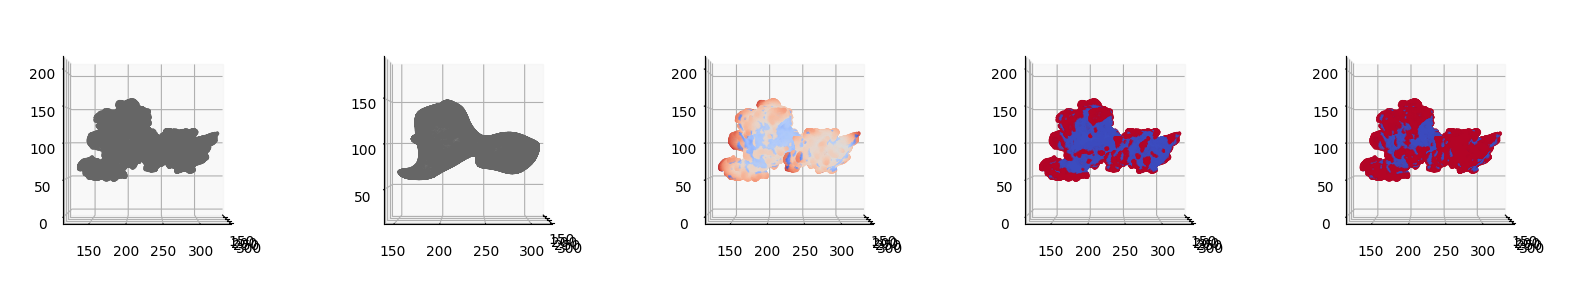

In [98]:
import skimage.filters as skfilters

# obtain the binary segmentation by mean value
cutoff_h_cMCF = np.nanmean(h_cMCF)
binary_h_cMCF = h_cMCF > cutoff_h_cMCF

# obtain the binary segmentation by otsu
cutoff_h_cMCF_otsu = skfilters.threshold_otsu(h_cMCF)
binary_h_cMCF_otsu = h_cMCF > cutoff_h_cMCF_otsu

# create colors for height and binary
h_cMCF_colors = vol_colors.get_colors(h_cMCF, 
                                        colormap=cm.coolwarm,
                                        vmin=np.percentile(h_cMCF,1),
                                        vmax=np.percentile(h_cMCF,99))

binary_h_cMCF_colors = vol_colors.get_colors(binary_h_cMCF*1, 
                                        colormap=cm.coolwarm,
                                        vmin=0,
                                        vmax=1)

binary_h_cMCF_otsu_colors = vol_colors.get_colors(binary_h_cMCF_otsu*1, 
                                        colormap=cm.coolwarm,
                                        vmin=0,
                                        vmax=1)

# visualize
sampling = 2

fig = plt.figure(figsize=(4*5,5))
ax = fig.add_subplot(1,5,1, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=mesh_S.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,2, projection='3d')
ax.scatter(cMCF_S_ref.vertices[::sampling,0], 
            cMCF_S_ref.vertices[::sampling,1],
            cMCF_S_ref.vertices[::sampling,2], 
            s=0.1, 
            c=cMCF_S_ref.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,3, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=h_cMCF_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,4, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=binary_h_cMCF_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,5, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=binary_h_cMCF_otsu_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
plt.show()

##### cMCF + distance function $S^\text{external cMCF}_\text{ref}(x,y,z)$ 

We will now binary segment by taking the mean of the height as cutoff and by Otsu's method. 

We then visualize side-by-side the 5 plots:
1. $S(x,y,z)$, 
2. $S^\text{external cMCF}_\text{ref}(x,y,z)$, 
3. $h_\text{external cMCF}$ 

and the binary segmentation by: 

4. mean value,
5. Otsu's method

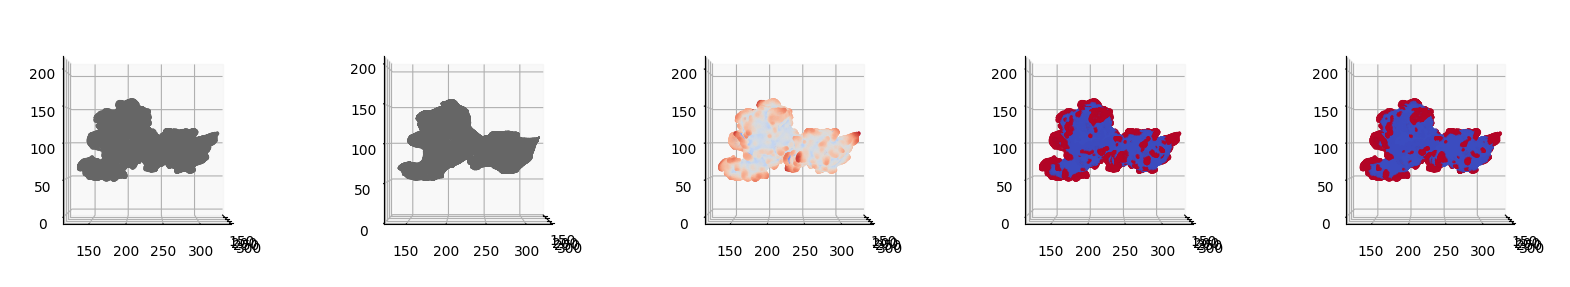

In [99]:
import skimage.filters as skfilters

# obtain the binary segmentation by mean value
cutoff_h_external_cMCF = np.nanmean(h_external_cMCF)
binary_h_external_cMCF = h_external_cMCF > cutoff_h_external_cMCF

# obtain the binary segmentation by otsu
cutoff_h_external_cMCF_otsu = skfilters.threshold_otsu(h_external_cMCF)
binary_h_external_cMCF_otsu = h_external_cMCF > cutoff_h_external_cMCF_otsu

# create colors for height and binary
h_external_cMCF_colors = vol_colors.get_colors(h_external_cMCF, 
                                        colormap=cm.coolwarm,
                                        vmin=np.percentile(h_external_cMCF,1),
                                        vmax=np.percentile(h_external_cMCF,99))

binary_h_external_cMCF_colors = vol_colors.get_colors(binary_h_external_cMCF*1, 
                                        colormap=cm.coolwarm,
                                        vmin=0,
                                        vmax=1)

binary_h_external_cMCF_otsu_colors = vol_colors.get_colors(binary_h_external_cMCF_otsu*1, 
                                        colormap=cm.coolwarm,
                                        vmin=0,
                                        vmax=1)

# visualize
sampling = 2

fig = plt.figure(figsize=(4*5,5))
ax = fig.add_subplot(1,5,1, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=mesh_S.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,2, projection='3d')
ax.scatter(external_ref_mesh.vertices[::sampling,0], 
            external_ref_mesh.vertices[::sampling,1],
            external_ref_mesh.vertices[::sampling,2], 
            s=0.1, 
            c=cMCF_S_ref.visual.vertex_colors[::sampling,:3]/255.)
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,3, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=h_external_cMCF_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,4, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=binary_h_external_cMCF_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,5, projection='3d')
ax.scatter(mesh_S.vertices[::sampling,0], 
            mesh_S.vertices[::sampling,1],
            mesh_S.vertices[::sampling,2], 
            s=0.1, 
            c=binary_h_external_cMCF_otsu_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
plt.show()

# export the mean value threshold mesh and height function colormap onto the shape
height_color_mesh = mesh_S.copy()
height_color_mesh.visual.vertex_colors = np.uint8(255.*h_external_cMCF_colors[:,:3])
tmp = height_color_mesh.export(os.path.join(savefolder,
                                            'external_cMCF_height_mesh.obj'))

binary_mean_height_color_mesh = mesh_S.copy()
binary_mean_height_color_mesh.visual.vertex_colors = np.uint8(255.*binary_h_external_cMCF_colors[:,:3])
tmp = binary_mean_height_color_mesh.export(os.path.join(savefolder,
                                            'binary_mean-value_external_cMCF_height_mesh.obj'))


##### ALS baseline $S^\text{ALS}_\text{ref}(d,u,v)$

We will now binary segment by taking the mean of the height as cutoff and by Otsu's method. Since the segmentation is in $(d,u,v)$ space, we will show the following plots in topography space, then we will then map $S(d,u,v)$ mesh back to $(x,y,z)$ space for comparison, consistent with the other height functions.

We then visualize side-by-side the 5 plots:
1. $S(d,u,v)$, 
2. $S^\text{ALS}_\text{ref}(d,u,v)$, 
3. $h_\text{ALS}(d,u,v)$

and the binary segmentation by: 

4. mean value,
5. Otsu's method

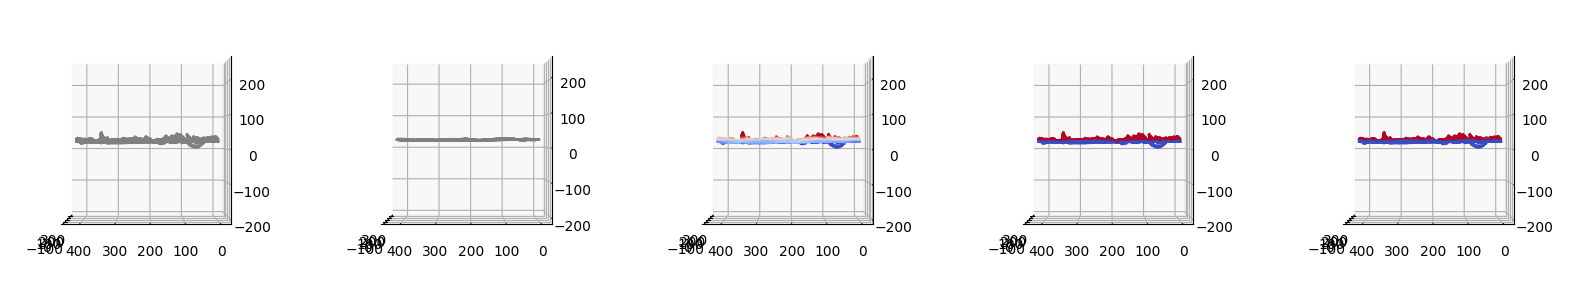

In [100]:
import skimage.filters as skfilters

# obtain the binary segmentation by mean value
cutoff_h_ALS_topo = np.nanmean(h_ALS_topo)
binary_h_ALS_topo = h_ALS_topo > cutoff_h_ALS_topo

# obtain the binary segmentation by otsu
cutoff_h_ALS_topo_otsu = skfilters.threshold_otsu(h_ALS_topo)
binary_h_ALS_topo_otsu = h_ALS_topo > cutoff_h_ALS_topo_otsu

# create colors for height and binary
h_ALS_topo_colors = vol_colors.get_colors(h_ALS_topo, 
                                        colormap=cm.coolwarm,
                                        vmin=np.percentile(h_ALS_topo,1),
                                        vmax=np.percentile(h_ALS_topo,99))

binary_h_ALS_topo_colors = vol_colors.get_colors(binary_h_ALS_topo*1, 
                                        colormap=cm.coolwarm,
                                        vmin=0,
                                        vmax=1)

binary_h_ALS_topo_otsu_colors = vol_colors.get_colors(binary_h_ALS_topo_otsu*1, 
                                        colormap=cm.coolwarm,
                                        vmin=0,
                                        vmax=1)

# visualize
sampling = 2

fig = plt.figure(figsize=(4*5,5))
ax = fig.add_subplot(1,5,1, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.1, 
            color=(0.5,0.5,0.5))
ax.view_init(0,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,2, projection='3d')
ax.scatter(mesh_Sref_duv.vertices[::sampling,1], 
            mesh_Sref_duv.vertices[::sampling,2],
            mesh_Sref_duv.vertices[::sampling,0], 
            s=0.1, 
            color=(0.5,0.5,0.5))
ax.view_init(0,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,3, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.1, 
            c=h_ALS_topo_colors[::sampling])
ax.view_init(0,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,4, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.1, 
            c=binary_h_ALS_topo_colors[::sampling])
ax.view_init(0,180)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,5, projection='3d')
ax.scatter(mesh_S_duv.vertices[::sampling,1], 
            mesh_S_duv.vertices[::sampling,2],
            mesh_S_duv.vertices[::sampling,0], 
            s=0.1, 
            c=binary_h_ALS_topo_otsu_colors[::sampling])
ax.view_init(0,180)
plotting.set_axes_equal(ax)
plt.show()



We will now map the topographic coordinates back to the Cartesian space to revisualize. 

Now we will plot:

We then visualize side-by-side the 5 plots:
1. $S(x,y,z)$, 
2. $S^\text{ALS}_\text{ref}(x,y,z)$, 
3. $h_\text{ALS}(x,y,z)$

and the binary segmentation by: 

4. mean value,
5. Otsu's method

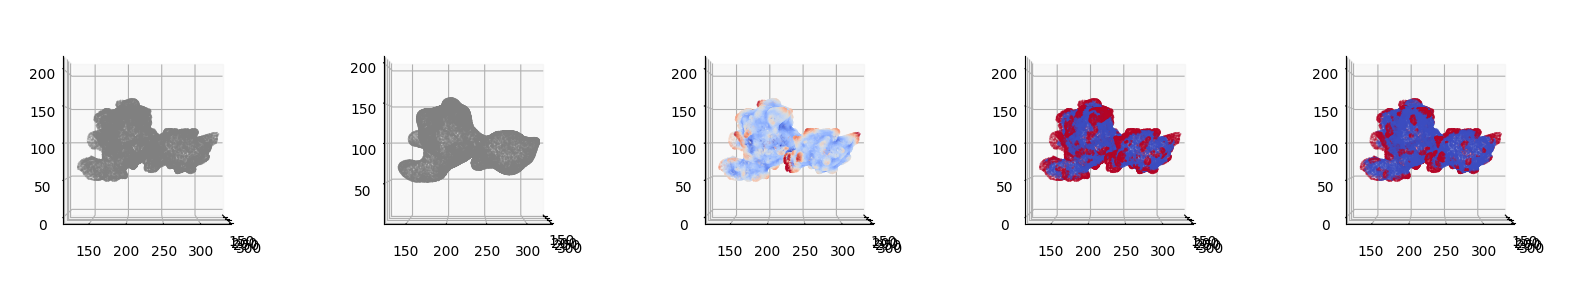

In [101]:
mesh_S_duv_to_xyz = topotools.uv_depth_pts3D_to_xyz_pts3D(mesh_S_duv.vertices, topographic_coordinates)
mesh_Sref_duv_to_xyz = topotools.uv_depth_pts3D_to_xyz_pts3D(mesh_Sref_duv.vertices, topographic_coordinates)

# visualize
sampling = 2

fig = plt.figure(figsize=(4*5,5))
ax = fig.add_subplot(1,5,1, projection='3d')
ax.scatter(mesh_S_duv_to_xyz[::sampling,0], 
            mesh_S_duv_to_xyz[::sampling,1],
            mesh_S_duv_to_xyz[::sampling,2], 
            s=0.1, 
            color=(0.5,0.5,0.5))
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,2, projection='3d')
ax.scatter(mesh_Sref_duv_to_xyz[::sampling,0], 
            mesh_Sref_duv_to_xyz[::sampling,1],
            mesh_Sref_duv_to_xyz[::sampling,2], 
            s=0.1, 
            color=(0.5,0.5,0.5))
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,3, projection='3d')
ax.scatter(mesh_S_duv_to_xyz[::sampling,0], 
            mesh_S_duv_to_xyz[::sampling,1],
            mesh_S_duv_to_xyz[::sampling,2], 
            s=0.1, 
            c=h_ALS_topo_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,4, projection='3d')
ax.scatter(mesh_S_duv_to_xyz[::sampling,0], 
            mesh_S_duv_to_xyz[::sampling,1],
            mesh_S_duv_to_xyz[::sampling,2], 
            s=0.1, 
            c=binary_h_ALS_topo_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,5,5, projection='3d')
ax.scatter(mesh_S_duv_to_xyz[::sampling,0], 
            mesh_S_duv_to_xyz[::sampling,1],
            mesh_S_duv_to_xyz[::sampling,2], 
            s=0.1, 
            c=binary_h_ALS_topo_otsu_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
plt.show()

#### 3. Postprocessing of segmentation

Inevitably there may be some imperfections in the segmentation e.g. too small areas, holes that should be filled or insufficient coverage of segmentation. u-Unwrap3D implements two essential postprocessing operations for cleaning up segmentations on meshes.

1. `unwrap3D.Mesh.meshtools.remove_small_mesh_components_binary` 

This removes small objects in the binary segmentation, based on either physical size (i.e. actual surface area) or by number of vertex points. Objects are defined as contiguous mesh areas.

2. `unwrap3D.Mesh.meshtools.labelspreading_mesh_binary`

This conducts adapts [labelspreading](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html) to work on meshes with a given affinity graph. 

We demonstrate the usage of both in application to the binary segmentation of $S^\text{ALS}_\text{ref}(d,u,v)$ obtained by mean value thresholding.

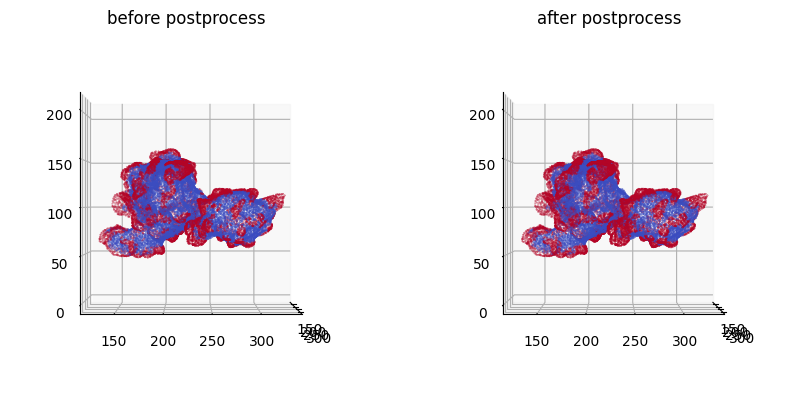

In [102]:
# 1. perform small object removal after mapping vertices for d,u,v to x,y,z space
vertex_labels_binary = meshtools.remove_small_mesh_components_binary(mesh_S_duv_to_xyz,
                                                                        mesh_S_duv.faces,
                                                                        labels=binary_h_ALS_topo*1, 
                                                                        vertex_labels_bool=True, 
                                                                        physical_size=True, 
                                                                        minsize=50) # you don't want to set this too low, as it might expand after diffusion.
        
# 2. perform diffusion which enforces spatial contiguity and propagates segmentation in (d,u,v)
# construct affinity matrix first. 
W_topography = meshtools.vertex_geometric_affinity_matrix(mesh_S_duv, 
                                                        gamma=None, 
                                                        eps=1e-12, 
                                                        alpha=.5, # weighting between distance vs convexity. The higher, the more weight to distance.
                                                        normalize=True)

z_label_props_labels, z_label_props_labels_proba = meshtools.labelspreading_mesh_binary(mesh_S_duv.vertices,
                                                                                        mesh_S_duv.faces,
                                                                                        (vertex_labels_binary==1)*1,
                                                                                        W=W_topography, 
                                                                                        niters=10, # how many iterations? 
                                                                                        return_proba=True, 
                                                                                        thresh=.5)# thresholding gives faster convergence

# 3. (optional, might be overkill) perform a second round of object removal 
vertex_labels_binary_new = meshtools.remove_small_mesh_label_holes_binary(mesh_S_duv_to_xyz,
                                                                        mesh_S_duv.faces,
                                                                        labels=np.array(z_label_props_labels)*1, 
                                                                        vertex_labels_bool=True, 
                                                                        physical_size=True, 
                                                                        minsize=200)

binary_h_ALS_topo_postprocess = (vertex_labels_binary_new>0).copy()
binary_h_ALS_topo_postprocess_colors = vol_colors.get_colors(binary_h_ALS_topo_postprocess,
                                                             colormap=cm.coolwarm,
                                                             vmin=0, vmax=1)

"""
re-visualize
"""
fig = plt.figure(figsize=(2*5,5))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.set_title('before postprocess')
ax.scatter(mesh_S_duv_to_xyz[::sampling,0], 
            mesh_S_duv_to_xyz[::sampling,1],
            mesh_S_duv_to_xyz[::sampling,2], 
            s=0.1, 
            c=binary_h_ALS_topo_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
ax = fig.add_subplot(1,2,2, projection='3d')
ax.set_title('after postprocess')
ax.scatter(mesh_S_duv_to_xyz[::sampling,0], 
            mesh_S_duv_to_xyz[::sampling,1],
            mesh_S_duv_to_xyz[::sampling,2], 
            s=0.1, 
            c=binary_h_ALS_topo_postprocess_colors[::sampling])
ax.view_init(0,0)
plotting.set_axes_equal(ax)
plt.show()


# lets save both meshes out for better viewing in external mesh viewers. 
mesh_S_duv_xyz_binary_mean = meshtools.create_mesh(vertices=mesh_S_duv_to_xyz,
                                                   faces=mesh_S_duv.faces,
                                                   vertex_colors=binary_h_ALS_topo_colors)
tmp = mesh_S_duv_xyz_binary_mean.export(os.path.join(savefolder, 
                                                        'binary_ALS_mean_threshold.obj'))

mesh_S_duv_xyz_binary_mean_postprocess = meshtools.create_mesh(vertices=mesh_S_duv_to_xyz,
                                                   faces=mesh_S_duv.faces,
                                                   vertex_colors=binary_h_ALS_topo_postprocess_colors)
tmp = mesh_S_duv_xyz_binary_mean_postprocess.export(os.path.join(savefolder, 
                                                                 'binary_ALS_mean_threshold_postprocess.obj'))


You can see that the segmentation has grown (diffused) larger after postprocessing.  

We could further take this output and combine with other filtering e.g. cross-checking with curvature, masking with instance protrusion segmentation etc. 